In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

## Baseline Clustering

### Random Orthogonal Projection

For this step, we are going to use a few categoric features of the data. Since we don't have any kind of taxonomy on the categories of each feature, the approach will be to use **random orthogonal projections** for the categories to be equidistant in the hyperspace. This way, we keep the representation unbiased - not placing some categories closer to other categories randomly.

Selected features (*italic features are being evaluated*):
- categoria (10 categories)
- *ano_de_confeccao (75 categories)*
- tipo_materia_prima (4 categories)
- *povo (187 categories)*
- *lingua (41 categories)*
- *estado_de_origem (27 categories)*

In [3]:
import ast

# Creating feature 'tipo_materia_prima'
tipo_materia_prima = []
for index, row in ind_df.iterrows():
    tipo_materia_prima_aux = []
    
    if type(row['materia_prima']) is not float:
        material_list = ast.literal_eval(row['materia_prima'])
        
        if len(material_list[0]) > 0:
            tipo_materia_prima_aux.append('animal')
        if len(material_list[1]) > 0:
            tipo_materia_prima_aux.append('vegetal')
        if len(material_list[2]) > 0:
            tipo_materia_prima_aux.append('mineral')
        if len(material_list[3]) > 0:
            tipo_materia_prima_aux.append('sintetico')

    tipo_materia_prima.append(tipo_materia_prima_aux)
    
ind_df['tipo_materia_prima'] = tipo_materia_prima
ind_df['tipo_materia_prima']

id
55663    [animal, vegetal]
55668            [vegetal]
55673                   []
55678                   []
55688                   []
               ...        
41913            [vegetal]
41918                   []
41923            [vegetal]
41928                   []
41933            [vegetal]
Name: tipo_materia_prima, Length: 20965, dtype: object

In [4]:
import numpy as np

# Fixing experiments for testing
np.random.seed(42)

# Generating random orthonormal projection (equidistant categorical representation)
def rand_ortho_mat(k):
    q = np.random.randn(k, k-1)
    q, _ = np.linalg.qr(q)
    return q

# Getting embeddings for each category in each feature
tipos_materia_prima = ['animal', 'vegetal', 'mineral', 'sintetico']
# estados = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA',\
#            'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN',\
#            'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO']

features = ['categoria', 'tipo_materia_prima'] #, 'estado_de_origem']
feature_index_map = []
qs = []
for feature in features:
    if feature == 'tipo_materia_prima':
        qs.append(rand_ortho_mat(len(tipos_materia_prima)))
        feature_index_map.append({k: i for i, k in enumerate(tipos_materia_prima)})
        
    # elif feature == 'estado_de_origem':
    #     qs.append(rand_ortho_mat(len(estados)))
    #     feature_index_map.append({k: i for i, k in enumerate(estados)})
    
    else:
        qs.append(rand_ortho_mat(ind_df[feature].nunique()))
        feature_index_map.append({k: i for i, k in enumerate(ind_df[feature].unique())})

# Projecting datapoints
features_size = ind_df['categoria'].nunique() + len(tipos_materia_prima) # + len(estados)
datapoints = []
for index, row in ind_df[~ind_df['image_path'].isnull()].iterrows():
    datapoint = []
    
    if type(row['categoria']) is not float:
        datapoint.append(qs[0][feature_index_map[0][row['categoria']]])
    else:
        datapoint.append(np.zeros_like(qs[0][0]))

    if type(row['tipo_materia_prima']) is not float:
        datapoint_aux = np.zeros_like(qs[1][0])
        for materia in row['tipo_materia_prima']:
            datapoint_aux += qs[1][feature_index_map[1][materia]]
        datapoint.append(datapoint_aux)
    else:
        datapoint.append(np.zeros_like(qs[1][0]))

    # if type(row['estado_de_origem']) is not float:
    #     datapoint_aux = np.zeros_like(qs[2][0])
    #     for estado in ast.literal_eval(row['estado_de_origem']):
    #         datapoint_aux += qs[2][feature_index_map[2][estado]]
    #     datapoint.append(datapoint_aux)
    # else:
    #     datapoint.append(np.zeros_like(qs[2][0]))

    datapoint = np.concatenate(datapoint)
    datapoints.append(datapoint)

datapoints = np.stack(datapoints)
print(f'Shape of the final array: {datapoints.shape}')

Shape of the final array: (11275, 12)


### Projecting Datapoints Onto Lower Dimensional Space

In here we try two main techniques, mainly because of their abilities to preserve distances between points (or rather global structure of the dataset). The first one is MDS, which should work alright for low-dimensional data, but is probably not the one to use on higher dimensionality. The second one is TriMap, a more general approach that should work well enough in high dimensional data as well. 

In [5]:
# MDS projection
from sklearn.manifold import MDS

proj_mds = MDS(n_components=2, n_init=1, n_jobs=1, eps=1e-3, normalized_stress='auto')
datapoints_proj_mds = proj_mds.fit_transform(datapoints)
print(f'Shape of projected array (MDS): {datapoints_proj_mds.shape}')

Shape of projected array (MDS): (11275, 2)


In [6]:
# TriMap projection
import trimap

proj_trimap = trimap.TRIMAP(n_dims=2, n_inliers=120, n_outliers=20, n_random=3,\
                            weight_temp=0.5, lr=0.1, apply_pca=True)
datapoints_proj_trimap = proj_trimap.fit_transform(datapoints)
print(f'Shape of projected array (TriMap): {datapoints_proj_trimap.shape}')

Shape of projected array (TriMap): (11275, 2)


In [7]:
# Normalizing projections to [-2, 2] while maintaining relative distances
def normalize(data):
    mean = np.mean(data)
    max_dev = np.max(np.abs(data-mean))
    
    return 2*(data-mean)/max_dev

datapoints_proj_mds = normalize(datapoints_proj_mds)
datapoints_proj_trimap = normalize(datapoints_proj_trimap)

In [8]:
%%skip

# Saving projections for testing on visualization tool
np.save('./data/baseline_mds.npy', datapoints_proj_mds)
np.save('./data/baseline_trimap.npy', datapoints_proj_trimap)

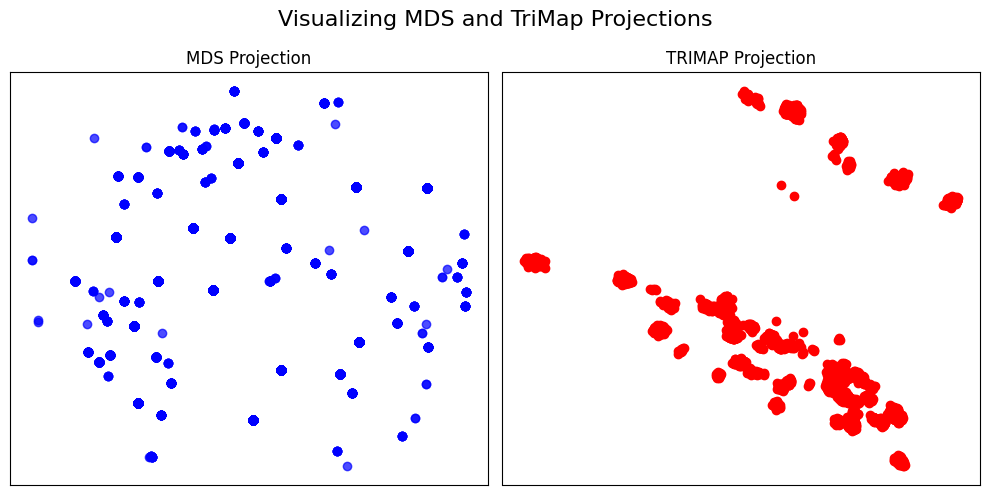

In [9]:
# Visualizing resulting projections
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.suptitle('Visualizing MDS and TriMap Projections', fontsize=16)

# Second subplot for MDS projection
plt.subplot(1, 2, 1)
plt.scatter(datapoints_proj_mds[:, 0], datapoints_proj_mds[:, 1], alpha=0.7, color='b')
plt.title("MDS Projection")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])

# First subplot for TRIMAP projection
plt.subplot(1, 2, 2)
plt.scatter(datapoints_proj_trimap[:, 0], datapoints_proj_trimap[:, 1], c='r')
plt.title("TRIMAP Projection")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

### Using Categorical Clustering Instead

Even though the experiment with random orthogonal projections was interesting, the data sparsity becomes a problem for meaningful clustering and visualization. Because of that, we went back to a more straightforward approach, doing categorical clustering on the data.

In [10]:
# Multi-hot encoding 'tipo_materia_prima'
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb_results = mlb.fit_transform(ind_df['tipo_materia_prima'].values)
ind_df[mlb.classes_] = mlb_results

# Encoding 'categoria'
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ind_df['categoria_num'] = le.fit_transform(ind_df['categoria'])

In [11]:
# Preparing data for clustering
datapoints = ind_df[['categoria_num'] + list(mlb.classes_)].values
datapoints

array([[9, 1, 0, 1],
       [9, 0, 0, 1],
       [9, 0, 0, 0],
       ...,
       [4, 0, 0, 1],
       [4, 0, 0, 0],
       [4, 0, 0, 1]])

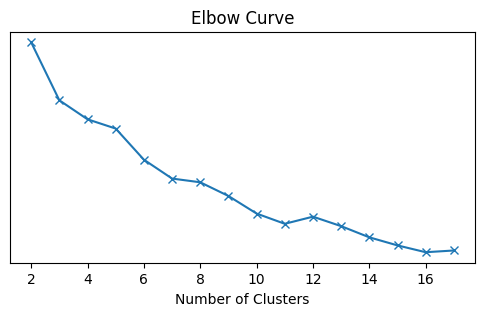

In [13]:
from kmodes.kmodes import KModes

# Elbow curve to find optimal k
costs = []
for k in range(2, 18):
    km = KModes(n_clusters=k, init='random', n_init=5)
    km.fit_predict(datapoints)
    costs.append(km.cost_)

plt.figure(figsize=(6, 3))
plt.plot(range(2, 18), costs, 'x-') 
plt.xlabel('Number of Clusters') 
plt.ylabel('')
plt.yticks([])
plt.title('Elbow Curve') 
plt.show()

In [14]:
# Getting categorical clusters
km = KModes(n_clusters=15, init='random', n_init=5)
clusters = km.fit_predict(datapoints)

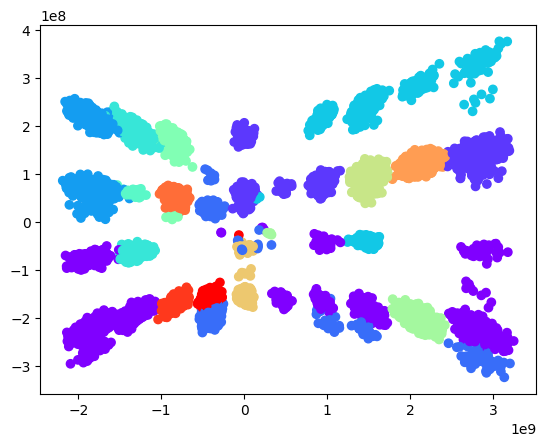

In [17]:
# Visualizing clusters
proj_trimap = trimap.TRIMAP(n_dims=2, n_inliers=50, n_outliers=5, n_random=3,\
                            weight_temp=0.5, lr=0.1, apply_pca=True)
datapoints_proj_trimap = proj_trimap.fit_transform(datapoints)

plt.scatter(datapoints_proj_trimap[:, 0], datapoints_proj_trimap[:, 1], c=clusters,\
            cmap='rainbow')